In [2]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import uproot, glob, time
import pandas as pd
import numpy as np
import os

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [3]:
path_to_reduced = '/p/lustre1/jacopod/30th/'
!ls $path_to_reduced

20200911_OvernightBi207_AfterFilling
20200912_MorningNoise_PreRecirculation
20200915_Night_AfterFirstRnInjection
20200916_Night_AfterSecondRnInjection
20200916_RnPoAlphaEffTest
20200917_Night_AfterThirdRnInjection
20200920_Rn220InParallel_RnPoTest
20200921_Afternoon_AfterFourthInjection
20200922_Afternoon_AfterFifthInjection
20200923_Afternoon_AfterSixthInjection
20200924_Afternoon_AfterSeventhInjection
log


out_df = pd.DataFrame()
for dr in os.scandir(path_to_reduced):
    if not ('Injection' in dr.path):
        continue
    folder = dr.path.split('/')[-1] + '/analysis_500ns'
    analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
    analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx',\
                                             folder)
    sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
    trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']
    df = pd.read_pickle(path_to_reduced + folder + '/reduced_added.p')
    df['Folder'] = [folder.split('/')[0]]*len(df)
    DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
    mask = (df['NumXTileChannelsHit']==1) & (df['NumYTileChannelsHit']==1) & (df['IsFull3D']==1)
    en_mask = mask & (df['TotalTileEnergy'][mask]*np.exp(DriftTime[mask]/90.0)>600)\
    & (df['TotalTileEnergy'][mask]*np.exp(DriftTime[mask]/90.0)<950) & (DriftTime<70)
    out_df = out_df.append(df.loc[en_mask], ignore_index=False)

In [4]:
folder = '20200921_Afternoon_AfterFourthInjection'
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx',\
                                         folder)
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']
out_df = pd.read_hdf('../data/data_for_lightmap.h5')

In [5]:
for k in out_df.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-1 Baseline
SiPM 1-1 Baseline RMS
SiPM 1-1 Induced Charge
SiPM 1-1 Pulse Area
SiPM 1-1 Pulse Height
SiPM 1-1 Pulse Time
SiPM 1-1 T10
SiPM 1-1 T20
SiPM 1-1 T5
SiPM 1-1 T80
SiPM 1-1 T90
SiPM 1-2 Baseline
SiPM 1-2 Baseline RMS
SiPM 1-2 Induced Charge
SiPM 1-2 Pulse Area
SiPM 1-2 Pulse Height
SiPM 1-2 Pulse Time
SiPM 1-2 T10
SiPM 1-2 T20
SiPM 1-2 T5
SiPM 1-2 T80
SiPM 1-2 T90
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Induced Charge
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
SiPM 1-4 Baseline
SiPM 1-4 Baseline RMS
SiPM 1-4 Induced Charge
SiPM 1-4 Pulse Area
SiPM 1-4 Pulse Height
SiPM 1-4 Pulse Time
SiPM 1-4 T10
SiPM 1-4 T20
SiPM 1-4 T5
SiPM 1-4 T80
SiPM 1-4 T90


In [8]:
import itertools
DriftTime = (out_df['TimeOfMaxChannel'] - trigger_time)*sampling_time
pos_x = list(itertools.chain(*out_df['Cluster X-Pos'].to_list()))
pos_y = list(itertools.chain(*out_df['Cluster Y-Pos'].to_list()))
pos_z = list(itertools.chain(*out_df['Cluster Z-Pos'].to_list()))

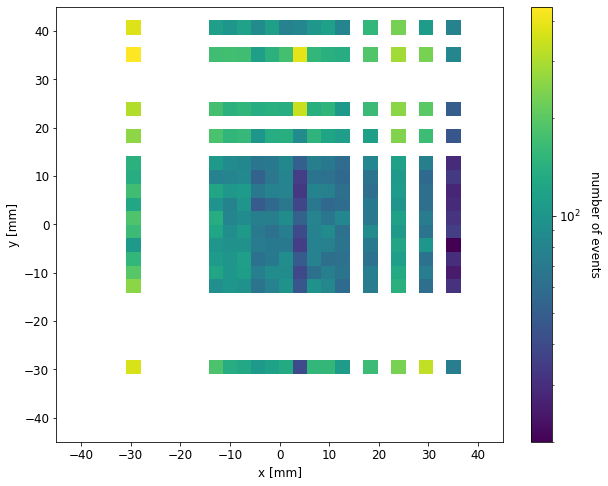

In [91]:
import itertools
plt.hist2d(pos_x,pos_y, bins=32,range=[[-45,45],[-45,45]], norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label('number of events', rotation=270, labelpad=20)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.show()

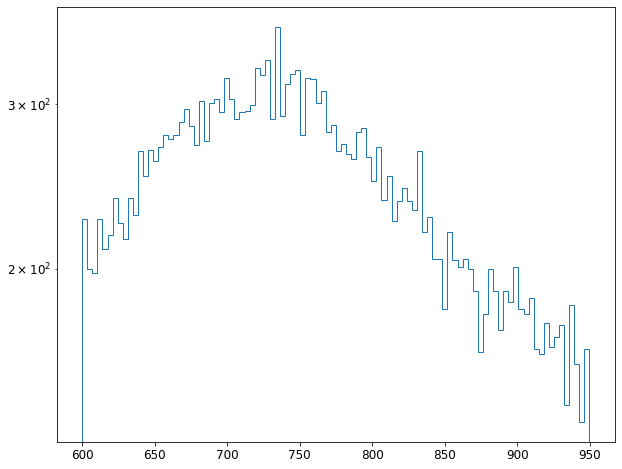

In [10]:
plt.hist(out_df['TotalTileEnergy']*np.exp(DriftTime/90.0),bins=100,histtype='step',log=True)
plt.show()

In [102]:
n_xy_bin = 33
n_z_bin = 10
xy_bin = np.linspace(-45,45,n_xy_bin)
z_bin = np.linspace(0,71,n_z_bin)
bin_x = np.digitize(pos_x,xy_bin)
bin_y = np.digitize(pos_y,xy_bin)
bin_z = np.digitize(pos_z,z_bin)
vxl = np.array((bin_x,bin_y,bin_z)).T
voxel = np.unique(vxl,axis=0)
mean_light_energy = np.mean(out_df['TotalSiPMEnergy'])
ly_matrix = np.ones((n_xy_bin+1,n_xy_bin+1,n_z_bin+1))
n_light_ev = np.zeros((n_xy_bin+1,n_xy_bin+1,n_z_bin+1))
for i,vl in enumerate(voxel):
    selection_idx = np.where(np.sum((vxl == vl).reshape(-1,3),axis=1) == 3)[0]
    light_energy_voxel = out_df['TotalSiPMEnergy'].iloc[selection_idx]
    ly_matrix[vl[0],vl[1],vl[2]] = np.mean(light_energy_voxel)/mean_light_energy
    n_light_ev[vl[0],vl[1],vl[2]] = selection_idx.shape[0]

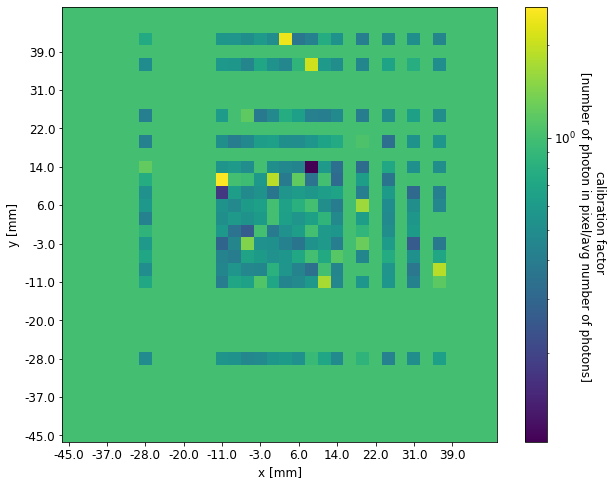

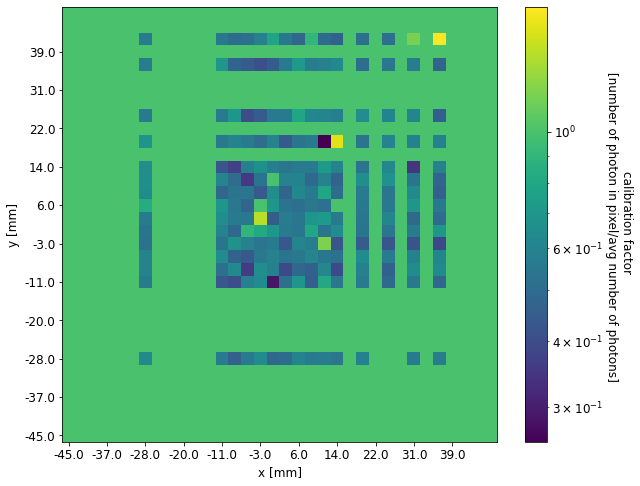

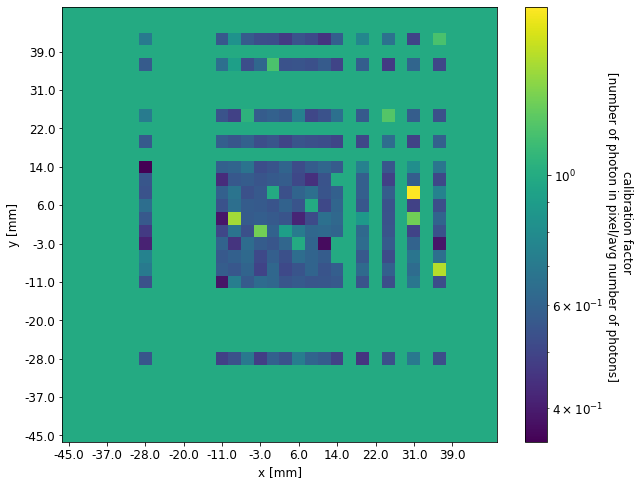

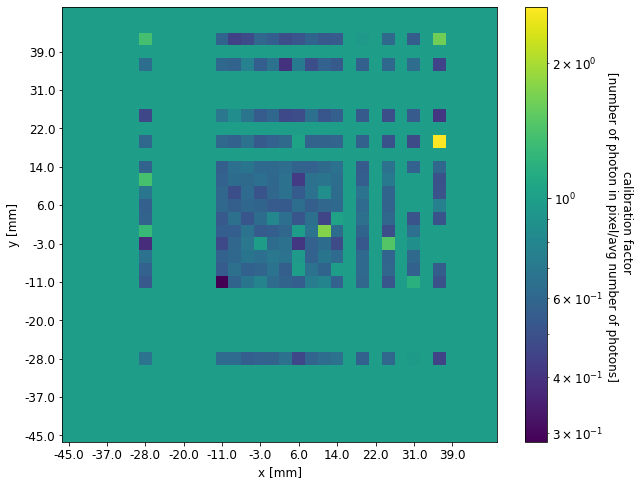

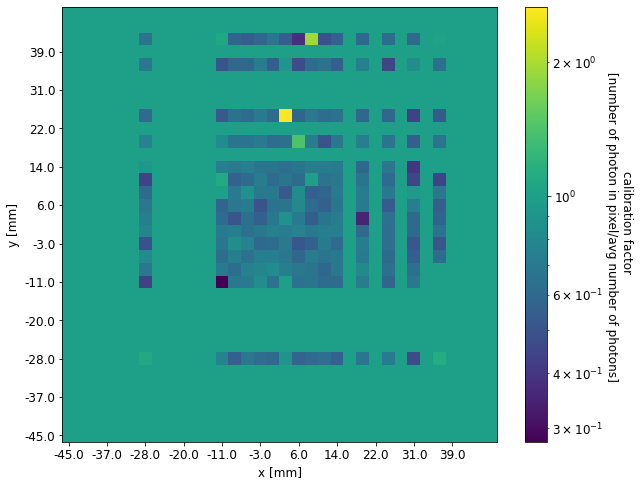

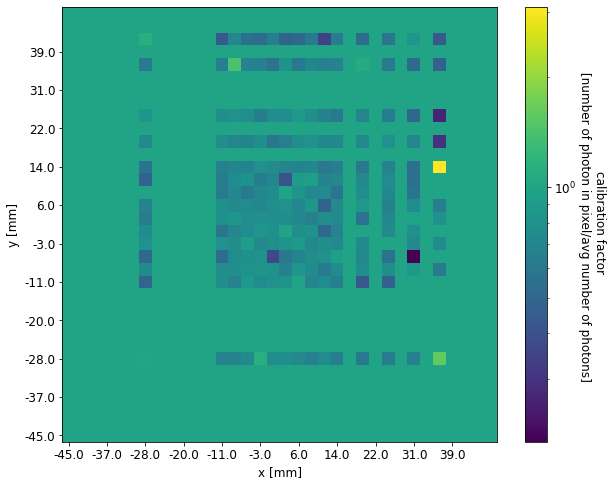

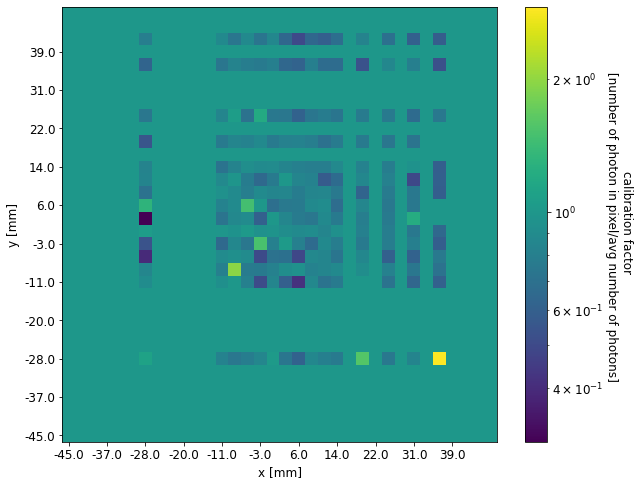

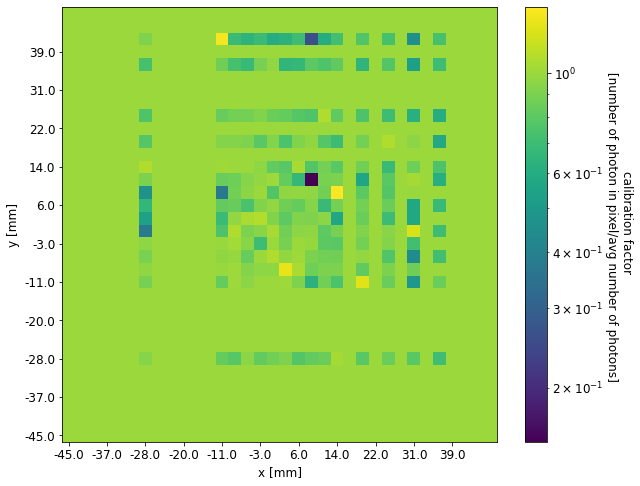

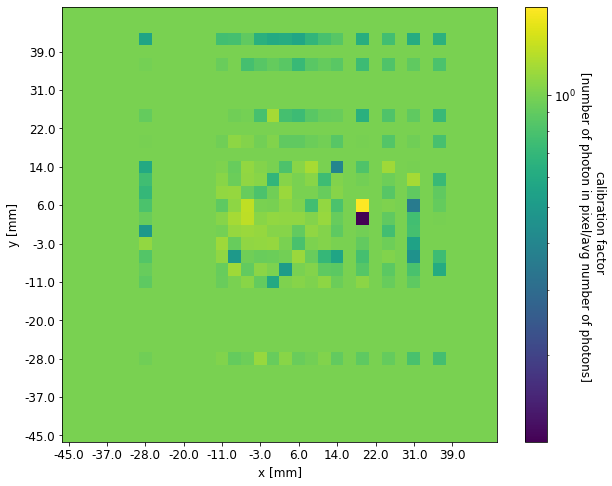

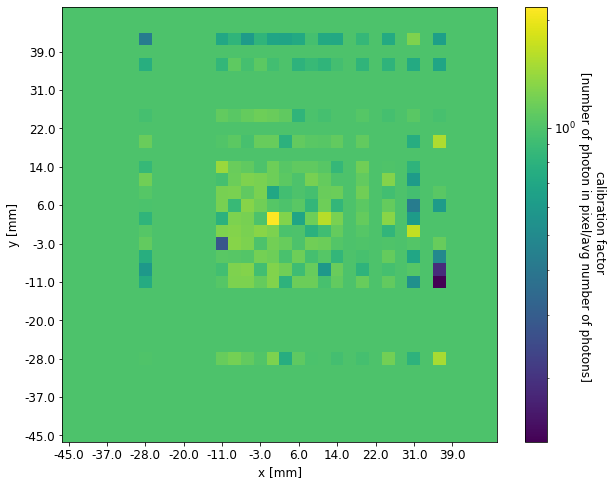

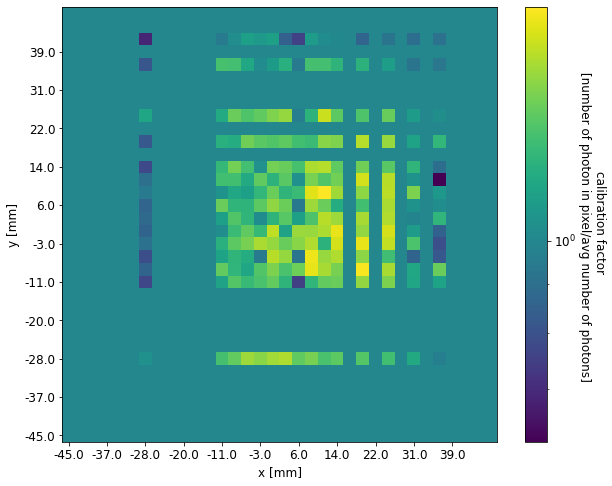

In [103]:
import matplotlib as mpl
for i in range(ly_matrix.shape[-1]):
    plt.imshow(ly_matrix[:,:,i].T,origin='lower',norm=mpl.colors.LogNorm())
    plt.xticks(range(n_xy_bin)[::3],np.round_(xy_bin[::3]))#,rotation=90)
    plt.yticks(range(n_xy_bin)[::3],np.round_(xy_bin[::3]))
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    cbar = plt.colorbar()
    cbar.set_label('calibration factor \n [number of photon in pixel/avg number of photons]', rotation=270, labelpad=30)
    #plt.text(0.6,0.9,'Drift Time: [{:.1f},{:.1f})$\mu$s'.format(z_bin[i],z_bin[i+1]),\
    #     transform = plt.gca().transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='none'))
    #plt.title('Drift Time: [{:.1f},{:.1f})$\mu$s'.format(z_bin[i],z_bin[i+1]))
    plt.show()

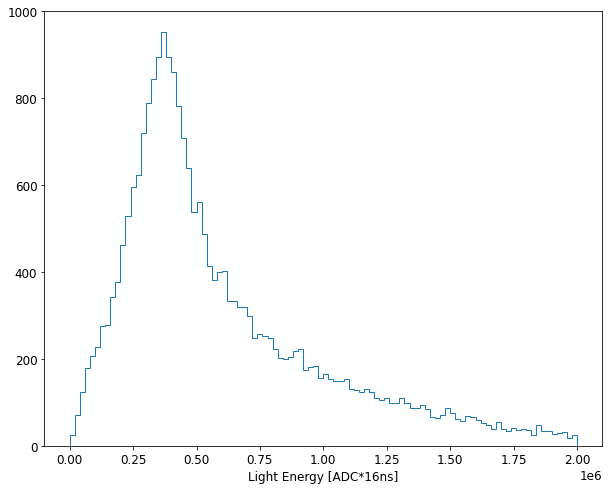

In [108]:
plt.hist(out_df['TotalSiPMEnergy'],bins=100,range=(0,2000000),histtype='step')
plt.xlabel('Light Energy [ADC*16ns]')
plt.show()

In [109]:
out_df['Correted Light'] = pd.Series()
for i,e in enumerate(out_df['TotalSiPMEnergy']):
    out_df['Correted Light'].iloc[i] = e/ly_matrix[bin_x[i],bin_y[i],bin_z[i]]

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [110]:
def fit_function(x, A, mu1, sigma1,B,mu2,sigma2):
    return (A  * np.exp(-1.0 * (x - mu1)**2 / (2 * sigma1**2)) + B  * np.exp(-1.0 * (x - mu2)**2 / (2 * sigma2**2)))

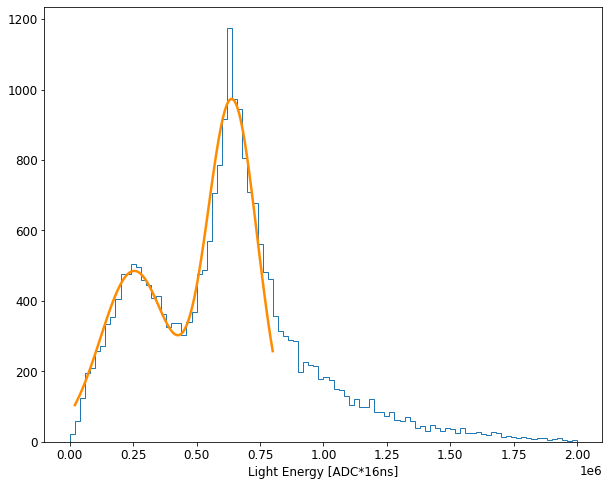

0.3965393676125825


In [118]:
#plt.plot(x_point,fit_function(x_point,)+fit_function(x_point, ))
p0 = [ 500, 250000, 130000,1000, 650000, 100000]
alpha_mask = DriftTime<50
gamma_mask = np.logical_not(alpha_mask)
data, bin_edges,_ = plt.hist(out_df['Correted Light'],bins=100,histtype='step',range=(0,2000000))
bin_width = bin_edges[1]-bin_edges[0]
fit_idx = np.where((bin_edges>20000) & (bin_edges<800000))[0]
popt, pcov = curve_fit(fit_function, xdata=bin_edges[fit_idx], ydata=data[fit_idx],p0=p0)
fit_x_bin = np.linspace(20000,800000,100)
plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.xlabel('Light Energy [ADC*16ns]')
#plt.hist(out_df['Correted Light'][alpha_mask],bins=100,histtype='step',range=(0,2000000),label='Drift Time<50$\mu$s')
#plt.hist(out_df['Correted Light'][gamma_mask],bins=100,histtype='step',range=(0,2000000),label='Drift Time>50$\mu$s')
#plt.legend()
plt.show()
print(popt[1]/popt[4])